In [38]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2 as cv
# import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [39]:
from zipfile import ZipFile
file_name = "dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [40]:
from zipfile import ZipFile
file_name = "datatest.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [41]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [42]:
df = pd.read_csv("features.csv")
dt = pd.read_csv("Data_test.csv")
df.head()

,Unnamed: 0,Energy_0,Corr_0,Homogen_0,Contrast_0,ASM_0,Energy_45,Corr_45,Homogen_45,Contrast_45,...,Homogen_90,Contrast_90,ASM_90,Energy_135,Corr_135,Homogen_135,Contrast_135,ASM_135,output,filenames
0,0,0.360166,0.849100,0.715262,400.557698,0.129720,0.352685,0.830636,0.695192,449.911262,...,0.697137,444.862077,0.129720,0.371847,0.867505,0.744380,352.059009,0.129720,0,dataset\0\fish_0.jpg
1,0,0.400987,0.812333,0.749640,407.428869,0.160791,0.408181,0.835459,0.768635,358.929444,...,0.721557,478.110919,0.160791,0.392616,0.782994,0.729269,473.488716,0.160791,0,dataset\0\fish_1.jpg
2,0,0.376491,0.877119,0.798621,690.161206,0.141746,0.378780,0.881331,0.804157,665.580926,...,0.821744,582.173172,0.141746,0.374711,0.873295,0.793183,711.160952,0.141746,0,dataset\0\fish_10.jpg
3,0,0.348277,0.832274,0.694796,652.404336,0.121297,0.349204,0.834127,0.699276,647.042470,...,0.707651,618.055012,0.121297,0.360706,0.865813,0.734265,523.300701,0.121297,0,dataset\0\fish_11.jpg
4,0,0.645835,0.895325,0.755612,431.792027,0.131375,0.321500,0.830256,0.627472,697.592628,...,0.627253,695.672415,0.131375,0.325453,0.848361,0.642111,623.203608,0.131375,0,dataset\0\fish_12.jpg


In [43]:
df.drop(['filenames'], axis=1, inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Energy_0,Corr_0,Homogen_0,Contrast_0,ASM_0,Energy_45,Corr_45,Homogen_45,Contrast_45,ASM_45,...,Corr_90,Homogen_90,Contrast_90,ASM_90,Energy_135,Corr_135,Homogen_135,Contrast_135,ASM_135,output
0,0.360166,0.849100,0.715262,400.557698,0.129720,0.352685,0.830636,0.695192,449.911262,0.129720,...,0.832495,0.697137,444.862077,0.129720,0.371847,0.867505,0.744380,352.059009,0.129720,0
1,0.400987,0.812333,0.749640,407.428869,0.160791,0.408181,0.835459,0.768635,358.929444,0.160791,...,0.781798,0.721557,478.110919,0.160791,0.392616,0.782994,0.729269,473.488716,0.160791,0
2,0.376491,0.877119,0.798621,690.161206,0.141746,0.378780,0.881331,0.804157,665.580926,0.141746,...,0.896054,0.821744,582.173172,0.141746,0.374711,0.873295,0.793183,711.160952,0.141746,0
3,0.348277,0.832274,0.694796,652.404336,0.121297,0.349204,0.834127,0.699276,647.042470,0.121297,...,0.842687,0.707651,618.055012,0.121297,0.360706,0.865813,0.734265,523.300701,0.121297,0
4,0.645835,0.895325,0.755612,431.792027,0.131375,0.321500,0.830256,0.627472,697.592628,0.131375,...,0.830514,0.627253,695.672415,0.131375,0.325453,0.848361,0.642111,623.203608,0.131375,0


In [44]:
label_distr = df['output'].value_counts()

label_name = ['Normal', 'RS', 'MAS', 'WS']

print(label_distr)

0    62
1    47
2    16
3    16
Name: output, dtype: int64


In [45]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [46]:
def decimal_scaling(data):
    data = np.array(data, dtype=np.float32)
    max_row = data.max(axis=0)
    c = np.array([len(str(int(number))) for number in np.abs(max_row)])
    return data / (10 ** c)


X = decimal_scaling(df[['Energy_0', 'Corr_0', 'Homogen_0', 'Contrast_0', 'ASM_0',
                        'Energy_45', 'Corr_45', 'Homogen_45', 'Contrast_45', 'ASM_45',
                        'Energy_90', 'Corr_90', 'Homogen_90', 'Contrast_90', 'ASM_90',
                        'Energy_135', 'Corr_135', 'Homogen_135', 'Contrast_135', 'ASM_135']].values)

In [47]:
le = LabelEncoder()
le.fit(df["output"].values)

print(" categorical label : \n", le.classes_)

Y = le.transform(df['output'].values)
Y = to_categorical(Y)

print("\n\n one hot encoding for sample 0 : \n", Y[0])

 categorical label : 
 [0 1 2 3]


 one hot encoding for sample 0 : 
 [1. 0. 0. 0.]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=42)

print("Dimensi data :\n")
print("X train \t X test \t Y train \t Y test")
print("%s \t %s \t %s \t %s" % (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimensi data :

X train 	 X test 	 Y train 	 Y test
(112, 20) 	 (29, 20) 	 (112, 4) 	 (29, 4)


In [49]:
from keras.models import Sequential
from keras.layers import Dense, Activation

import keras
from keras import backend as K

In [50]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def nn_model(max_len):
    model = Sequential()
    model.add(Dense(32,
                    activation="elu",
                    input_shape=(max_len,)))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(64, activation="elu"))
    model.add(Dense(32, activation="elu"))
    model.add(Dense(16, activation="elu"))
    model.add(Dense(4))
    model.add(Activation("sigmoid"))

    model.summary()

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall])
    return model


def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    hist = model_.fit(x,
                      y,
                      epochs=epochs_,
                      batch_size=batch_size_,
                      validation_data=(x_val, y_val))
    return hist

In [51]:
max_len = X_train.shape[1]

EPOCHS = 500
BATCH_SIZE = 32

model = nn_model(max_len)
history = check_model(model, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                672       
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
 activation_1 (Activation)   (None, 4)                

Epoch 32/500
4/4 [==============================] - 0s 9ms/step - loss: 0.8433 - accuracy: 0.6607 - precision: 0.7500 - recall: 0.5078 - val_loss: 0.8196 - val_accuracy: 0.6552 - val_precision: 0.7241 - val_recall: 0.4884
Epoch 33/500
4/4 [==============================] - 0s 9ms/step - loss: 0.8372 - accuracy: 0.6696 - precision: 0.7500 - recall: 0.5041 - val_loss: 0.8111 - val_accuracy: 0.6552 - val_precision: 0.7241 - val_recall: 0.4667
Epoch 34/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8333 - accuracy: 0.6607 - precision: 0.7656 - recall: 0.4823 - val_loss: 0.8083 - val_accuracy: 0.6552 - val_precision: 0.7586 - val_recall: 0.4889
Epoch 35/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8347 - accuracy: 0.6429 - precision: 0.7656 - recall: 0.4737 - val_loss: 0.8102 - val_accuracy: 0.6552 - val_precision: 0.7586 - val_recall: 0.4783
Epoch 36/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8222 - accuracy: 0.6607 - precision: 0

Epoch 69/500
4/4 [==============================] - 0s 8ms/step - loss: 0.7251 - accuracy: 0.6786 - precision: 0.8828 - recall: 0.5468 - val_loss: 0.7260 - val_accuracy: 0.6207 - val_precision: 0.8621 - val_recall: 0.5435
Epoch 70/500
4/4 [==============================] - 0s 9ms/step - loss: 0.7253 - accuracy: 0.7143 - precision: 0.8750 - recall: 0.5459 - val_loss: 0.7254 - val_accuracy: 0.7241 - val_precision: 0.8621 - val_recall: 0.5102
Epoch 71/500
4/4 [==============================] - 0s 8ms/step - loss: 0.7166 - accuracy: 0.7500 - precision: 0.8750 - recall: 0.5302 - val_loss: 0.7194 - val_accuracy: 0.6552 - val_precision: 0.8621 - val_recall: 0.5102
Epoch 72/500
4/4 [==============================] - 0s 8ms/step - loss: 0.7220 - accuracy: 0.7232 - precision: 0.8516 - recall: 0.5413 - val_loss: 0.7187 - val_accuracy: 0.7241 - val_precision: 0.8621 - val_recall: 0.5208
Epoch 73/500
4/4 [==============================] - 0s 9ms/step - loss: 0.7230 - accuracy: 0.7500 - precision: 0

Epoch 106/500
4/4 [==============================] - 0s 9ms/step - loss: 0.6046 - accuracy: 0.7946 - precision: 0.8984 - recall: 0.5475 - val_loss: 0.5862 - val_accuracy: 0.7931 - val_precision: 0.9310 - val_recall: 0.5870
Epoch 107/500
4/4 [==============================] - 0s 9ms/step - loss: 0.6084 - accuracy: 0.8036 - precision: 0.9141 - recall: 0.5570 - val_loss: 0.5676 - val_accuracy: 0.6897 - val_precision: 0.8966 - val_recall: 0.5778
Epoch 108/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5989 - accuracy: 0.8036 - precision: 0.8906 - recall: 0.5507 - val_loss: 0.5564 - val_accuracy: 0.7586 - val_precision: 0.8966 - val_recall: 0.5778
Epoch 109/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6020 - accuracy: 0.7946 - precision: 0.9141 - recall: 0.5398 - val_loss: 0.5583 - val_accuracy: 0.7241 - val_precision: 0.8966 - val_recall: 0.6047
Epoch 110/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6137 - accuracy: 0.7679 - prec

Epoch 143/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5069 - accuracy: 0.7946 - precision: 0.9297 - recall: 0.5097 - val_loss: 0.4760 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5625
Epoch 144/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5140 - accuracy: 0.8036 - precision: 0.9297 - recall: 0.5066 - val_loss: 0.4695 - val_accuracy: 0.7586 - val_precision: 0.9310 - val_recall: 0.5400
Epoch 145/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5202 - accuracy: 0.8125 - precision: 0.9453 - recall: 0.5156 - val_loss: 0.4620 - val_accuracy: 0.7931 - val_precision: 0.9310 - val_recall: 0.5294
Epoch 146/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5030 - accuracy: 0.8036 - precision: 0.9219 - recall: 0.5043 - val_loss: 0.4669 - val_accuracy: 0.7586 - val_precision: 0.9310 - val_recall: 0.5294
Epoch 147/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5060 - accuracy: 0.7946 - precis

Epoch 180/500
4/4 [==============================] - 0s 8ms/step - loss: 0.5223 - accuracy: 0.7946 - precision: 0.9297 - recall: 0.5088 - val_loss: 0.4240 - val_accuracy: 0.8276 - val_precision: 0.9655 - val_recall: 0.5385
Epoch 181/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5011 - accuracy: 0.8125 - precision: 0.9219 - recall: 0.4944 - val_loss: 0.4742 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5000
Epoch 182/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4947 - accuracy: 0.8214 - precision: 0.9297 - recall: 0.4861 - val_loss: 0.4485 - val_accuracy: 0.7931 - val_precision: 0.9310 - val_recall: 0.5192
Epoch 183/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5270 - accuracy: 0.7857 - precision: 0.9297 - recall: 0.4936 - val_loss: 0.4508 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5400
Epoch 184/500
4/4 [==============================] - 0s 8ms/step - loss: 0.5237 - accuracy: 0.7946 - precisi

Epoch 217/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4395 - accuracy: 0.8214 - precision: 0.9688 - recall: 0.5065 - val_loss: 0.4035 - val_accuracy: 0.8621 - val_precision: 0.9655 - val_recall: 0.5490
Epoch 218/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4320 - accuracy: 0.8304 - precision: 0.9688 - recall: 0.5061 - val_loss: 0.4232 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5400
Epoch 219/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4603 - accuracy: 0.8304 - precision: 0.9531 - recall: 0.4921 - val_loss: 0.3936 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5294
Epoch 220/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4297 - accuracy: 0.8482 - precision: 0.9688 - recall: 0.5001 - val_loss: 0.3977 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5510
Epoch 221/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4278 - accuracy: 0.8393 - precisi

Epoch 254/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4271 - accuracy: 0.8482 - precision: 0.9688 - recall: 0.4888 - val_loss: 0.3891 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5294
Epoch 255/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4072 - accuracy: 0.8482 - precision: 0.9766 - recall: 0.4942 - val_loss: 0.3916 - val_accuracy: 0.8276 - val_precision: 0.9655 - val_recall: 0.5385
Epoch 256/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4337 - accuracy: 0.8304 - precision: 0.9688 - recall: 0.4894 - val_loss: 0.4009 - val_accuracy: 0.8276 - val_precision: 0.9655 - val_recall: 0.5490
Epoch 257/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4486 - accuracy: 0.8393 - precision: 0.9688 - recall: 0.4808 - val_loss: 0.3847 - val_accuracy: 0.8276 - val_precision: 0.9310 - val_recall: 0.5510
Epoch 258/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3974 - accuracy: 0.8661 - precisi

Epoch 291/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3794 - accuracy: 0.8214 - precision: 0.9766 - recall: 0.4884 - val_loss: 0.3878 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.5472
Epoch 292/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3880 - accuracy: 0.8661 - precision: 0.9688 - recall: 0.4865 - val_loss: 0.3998 - val_accuracy: 0.8276 - val_precision: 0.9655 - val_recall: 0.5385
Epoch 293/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3765 - accuracy: 0.8571 - precision: 0.9766 - recall: 0.4813 - val_loss: 0.3812 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.5179
Epoch 294/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3830 - accuracy: 0.8393 - precision: 0.9766 - recall: 0.4851 - val_loss: 0.3958 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.5370
Epoch 295/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3723 - accuracy: 0.8393 - precisi

Epoch 328/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3712 - accuracy: 0.8482 - precision: 0.9688 - recall: 0.4864 - val_loss: 0.4323 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.5273
Epoch 329/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3656 - accuracy: 0.8571 - precision: 0.9844 - recall: 0.4889 - val_loss: 0.3698 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.4833
Epoch 330/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3536 - accuracy: 0.8393 - precision: 0.9766 - recall: 0.4718 - val_loss: 0.4029 - val_accuracy: 0.8276 - val_precision: 0.9655 - val_recall: 0.5185
Epoch 331/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3502 - accuracy: 0.8750 - precision: 0.9844 - recall: 0.4773 - val_loss: 0.3863 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 332/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3523 - accuracy: 0.8571 - precisi

Epoch 365/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3337 - accuracy: 0.8750 - precision: 0.9766 - recall: 0.4904 - val_loss: 0.3905 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.5179
Epoch 366/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3367 - accuracy: 0.8393 - precision: 0.9844 - recall: 0.4775 - val_loss: 0.3820 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.4833
Epoch 367/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3552 - accuracy: 0.8482 - precision: 0.9844 - recall: 0.4717 - val_loss: 0.3826 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 368/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3262 - accuracy: 0.8750 - precision: 0.9766 - recall: 0.4813 - val_loss: 0.3927 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.4833
Epoch 369/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3467 - accuracy: 0.8750 - precisi

Epoch 402/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3117 - accuracy: 0.8750 - precision: 0.9844 - recall: 0.4841 - val_loss: 0.4124 - val_accuracy: 0.8276 - val_precision: 0.9655 - val_recall: 0.4590
Epoch 403/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3566 - accuracy: 0.8661 - precision: 0.9844 - recall: 0.4487 - val_loss: 0.3875 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4677
Epoch 404/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3461 - accuracy: 0.8571 - precision: 0.9531 - recall: 0.4841 - val_loss: 0.4177 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 405/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3216 - accuracy: 0.8750 - precision: 0.9922 - recall: 0.4598 - val_loss: 0.3827 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4531
Epoch 406/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3233 - accuracy: 0.8571 - precisi

Epoch 439/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3043 - accuracy: 0.8839 - precision: 1.0000 - recall: 0.4643 - val_loss: 0.3854 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4603
Epoch 440/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3115 - accuracy: 0.8929 - precision: 0.9844 - recall: 0.4726 - val_loss: 0.3949 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4677
Epoch 441/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2771 - accuracy: 0.9107 - precision: 1.0000 - recall: 0.4813 - val_loss: 0.3782 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4754
Epoch 442/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2714 - accuracy: 0.9196 - precision: 0.9922 - recall: 0.4759 - val_loss: 0.3837 - val_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.4754
Epoch 443/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2745 - accuracy: 0.9107 - precisi

Epoch 476/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2678 - accuracy: 0.9196 - precision: 0.9766 - recall: 0.4764 - val_loss: 0.4821 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 477/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2911 - accuracy: 0.8839 - precision: 0.9922 - recall: 0.4803 - val_loss: 0.3814 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4603
Epoch 478/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2851 - accuracy: 0.9018 - precision: 0.9922 - recall: 0.4430 - val_loss: 0.3683 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4677
Epoch 479/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2963 - accuracy: 0.9107 - precision: 0.9922 - recall: 0.4796 - val_loss: 0.4845 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.4915
Epoch 480/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2798 - accuracy: 0.9107 - precisi

In [52]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.head(500)

,epoch,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,1,1.319387,0.321429,0.703125,0.370695,1.227196,0.482759,0.793103,0.396552
1,2,1.218782,0.508929,0.781250,0.390625,1.157516,0.586207,0.793103,0.396552
2,3,1.185793,0.571429,0.773438,0.386719,1.127947,0.620690,0.793103,0.396552
3,4,1.167144,0.580357,0.773438,0.386719,1.096605,0.620690,0.793103,0.396552
4,5,1.129654,0.589286,0.781250,0.390625,1.059723,0.620690,0.793103,0.403509
...,...,...,...,...,...,...,...,...,...
495,496,0.276102,0.910714,0.984375,0.482212,0.442523,0.862069,1.000000,0.483333
496,497,0.291141,0.848214,0.992188,0.459100,0.369672,0.827586,1.000000,0.460317
497,498,0.306616,0.892857,0.984375,0.464240,0.404816,0.862069,1.000000,0.460317
498,499,0.338849,0.848214,0.984375,0.458451,0.426798,0.862069,0.965517,0.466667


In [53]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
469,470,0.304375,0.901786,1.0,0.453276,0.337856,0.896552,1.0,0.453125


In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                672       
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
 activation_1 (Activation)   (None, 4)                

In [55]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [56]:
 # predict test data
y_pred= model.predict(X_test)
print(y_pred)

[[2.37e-03 3.36e-01 7.96e-01 9.86e-01]
 [1.00e+00 8.55e-01 4.49e-07 1.63e-02]
 [2.26e-03 9.81e-01 9.91e-01 4.53e-04]
 [2.05e-03 9.52e-01 9.85e-01 5.23e-03]
 [9.06e-01 6.99e-01 1.57e-01 2.56e-02]
 [0.00e+00 1.00e+00 1.00e+00 3.63e-33]
 [0.00e+00 1.00e+00 1.00e+00 1.51e-38]
 [9.95e-01 9.45e-01 6.93e-09 1.65e-01]
 [0.00e+00 1.00e+00 1.00e+00 2.29e-31]
 [9.95e-01 9.45e-01 6.93e-09 1.65e-01]
 [4.62e-01 9.17e-01 3.55e-06 8.91e-01]
 [1.35e-09 1.00e+00 9.99e-01 3.95e-03]
 [9.86e-01 6.56e-01 1.74e-05 7.26e-01]
 [9.83e-01 4.53e-01 5.31e-04 6.94e-01]
 [9.83e-01 4.53e-01 5.31e-04 6.94e-01]
 [0.00e+00 1.00e+00 1.00e+00 1.50e-30]
 [3.79e-10 1.00e+00 1.00e+00 5.41e-06]
 [0.00e+00 1.00e+00 1.00e+00 1.73e-25]
 [9.96e-01 9.52e-01 9.30e-03 3.88e-04]
 [9.93e-01 7.45e-01 3.24e-06 4.81e-01]
 [2.37e-03 3.36e-01 7.96e-01 9.86e-01]
 [9.92e-01 9.62e-01 1.87e-09 1.82e-01]
 [9.59e-01 7.09e-01 1.92e-05 7.04e-01]
 [9.88e-01 6.62e-01 1.51e-05 6.98e-01]
 [5.12e-10 1.00e+00 1.00e+00 8.78e-03]
 [9.99e-01 9.76e-01 2.46e

In [57]:
predict = []
for i in range(0, 16):
    predict.append(max(y_pred[i]))
predict

[0.9858576,
 0.9995787,
 0.99057907,
 0.98543614,
 0.90620375,
 1.0,
 1.0,
 0.9951972,
 1.0,
 0.9951972,
 0.91676766,
 0.99987346,
 0.9862865,
 0.98279035,
 0.98279035,
 1.0]

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

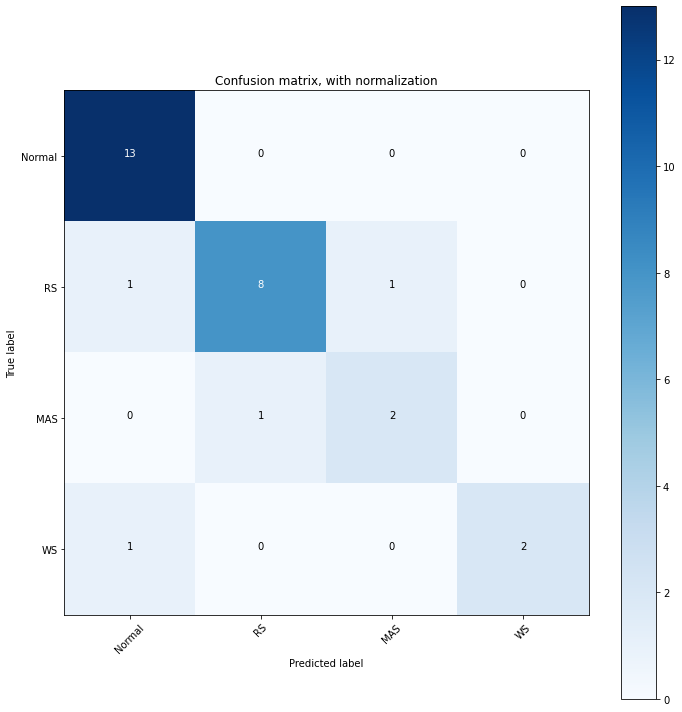

In [59]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix,
                      classes=['Normal', 'RS', 'MAS', 'WS'],
                      normalize=False,
                      title='Confusion matrix, with normalization')

In [60]:
print(classification_report(y_test.argmax(axis=1),
                            y_pred.argmax(axis=1),
                            target_names=['Normal', 'RS', 'MAS', 'WS']))

              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93        13
          RS       0.89      0.80      0.84        10
         MAS       0.67      0.67      0.67         3
          WS       1.00      0.67      0.80         3

    accuracy                           0.86        29
   macro avg       0.86      0.78      0.81        29
weighted avg       0.87      0.86      0.86        29



In [61]:
ytest = dt['output']
xtest = dt.drop(columns=['Unnamed: 0', 'output', 'filenames'])
xtest = preprocessing.StandardScaler().fit(xtest).transform(xtest.astype(float))
dt.head()

,Unnamed: 0,Energy_0,Corr_0,Homogen_0,Contrast_0,ASM_0,Energy_45,Corr_45,Homogen_45,Contrast_45,...,Homogen_90,Contrast_90,ASM_90,Energy_135,Corr_135,Homogen_135,Contrast_135,ASM_135,output,filenames
0,0,0.238833,0.517603,0.412533,3069.396847,0.057041,0.232840,0.481561,0.384189,3294.214195,...,0.379124,3528.956028,0.057041,0.242723,0.514698,0.431989,3083.943518,0.057041,0,dataset/0/fish_0.jpg
1,0,0.238353,0.512358,0.413436,3262.862123,0.056812,0.242940,0.525515,0.433085,3173.205623,...,0.367355,3774.753721,0.056812,0.230253,0.464397,0.376618,3582.181970,0.056812,0,dataset/0/fish_1.jpg
2,0,0.259169,0.445380,0.457163,3189.128320,0.067168,0.262902,0.466383,0.471457,3070.517608,...,0.523060,2503.627934,0.067168,0.263560,0.471281,0.475134,3042.272336,0.067168,0,dataset/0/fish_3.jpg
3,0,0.269625,0.548643,0.496141,3177.300241,0.072697,0.252457,0.419631,0.438557,4074.419555,...,0.421847,4255.804873,0.072697,0.251784,0.413907,0.434164,4114.603695,0.072697,0,dataset/0/fish_2.jpg
4,0,0.262031,0.443838,0.461995,3248.030262,0.068660,0.266288,0.473357,0.478816,3078.603990,...,0.577084,2064.272280,0.068660,0.269411,0.490361,0.489698,2979.088552,0.068660,0,dataset/0/fish_6.jpg


In [62]:
le = LabelEncoder()
le.fit(dt["output"].values)

print(" categorical label : \n", le.classes_)

y2 = le.transform(dt['output'].values)
y2 = to_categorical(y2)

print("\n\n one hot encoding for sample 0 : \n", y2[0])

 categorical label : 
 [0 1 2 3]


 one hot encoding for sample 0 : 
 [1. 0. 0. 0.]


In [63]:
y2test = y2

In [64]:
xtest.shape, y2test.shape

((82, 20), (82, 4))

In [65]:
from sklearn.metrics import accuracy_score

In [66]:
ypredict = model.predict(xtest)
print(ypredict)

[[6.78e-03 1.00e+00 1.16e-26 1.00e+00]
 [1.44e-01 1.00e+00 1.51e-25 1.00e+00]
 [1.56e-11 1.00e+00 0.00e+00 1.91e-02]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [1.81e-13 1.00e+00 1.95e-25 2.54e-01]
 [0.00e+00 1.00e+00 1.00e+00 1.83e-29]
 [1.70e-02 1.00e+00 0.00e+00 1.31e-08]
 [4.64e-08 1.00e+00 0.00e+00 1.00e+00]
 [1.73e-12 1.00e+00 0.00e+00 7.38e-05]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 1.00e+00 7.66e-18]
 [4.89e-05 1.00e+00 0.00e+00 1.00e+00]
 [1.00e+00 1.00e+00 1.15e-18 3.47e-21]
 [1.00e+00 1.00e+00 0.00e+00 1.37e-36]
 [6.06e-36 1.00e+00 1.11e-04 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 1.00e+00 1.00e+00]
 [0.00e+00 1.00e+00 1.00e+00 1.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 1.00e+00 2.39e-18]
 [1.24e-34 1.00e+00 1.00e+00 1.69e-37]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [3.30e-37 1.00e+00 7.20e-08 1.00e+00]
 [0.00e+00 1.00e+00 1.00e

In [67]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2test.argmax(axis=1), ypredict.argmax(axis=1))
np.set_printoptions(precision=2)

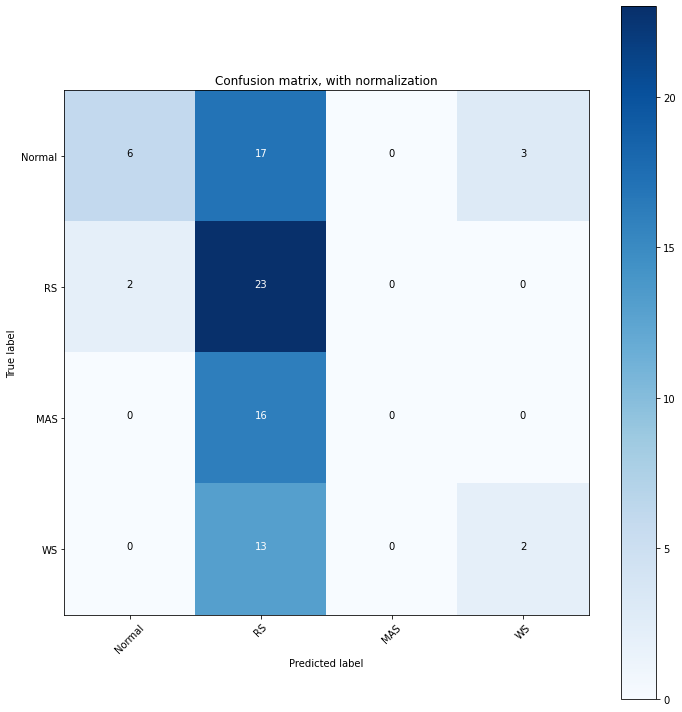

In [68]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix,
                      classes=['Normal', 'RS', 'MAS', 'WS'],
                      normalize=False,
                      title='Confusion matrix, with normalization')

In [69]:
print(classification_report(y2test.argmax(axis=1),
                            ypredict.argmax(axis=1),
                            target_names=['Normal', 'RS', 'MAS', 'WS']))

              precision    recall  f1-score   support

      Normal       0.75      0.23      0.35        26
          RS       0.33      0.92      0.49        25
         MAS       0.00      0.00      0.00        16
          WS       0.40      0.13      0.20        15

    accuracy                           0.38        82
   macro avg       0.37      0.32      0.26        82
weighted avg       0.41      0.38      0.30        82



D:\Anaconda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [71]:
import gradio as gr
import cv2

from sklearn.cluster import KMeans
from skimage.feature import greycomatrix, greycoprops

In [72]:
def preprocessing(img):
    resized = cv2.resize(img, (256, 256), Image.BICUBIC)
    bgr = resized[:, :, ::-1].copy()

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=0)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    lab[:, :, 1] = clahe.apply(lab[:, :, 1])
    lab[:, :, 2] = clahe.apply(lab[:, :, 2])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    res = cv2.fastNlMeansDenoisingColored(bgr, None, 10, 10, 1, 3)
    #bgr = cv2.bilateralFilter(bgr, 5, 1, 1)
    return res


def segmentation(img, online=False):
    pre = preprocessing(img)
    image = cv2.cvtColor(pre, cv2.COLOR_BGR2LAB)
    image = image.reshape((256 * 256, 3))

    clt = KMeans(n_clusters=5)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]
    quant = quant.reshape((256, 256, 3))
    res = image.reshape((256, 256, 3))

    if online:
        return quant

    return res


def gray_segmentation(img):
    pre = preprocessing(img)
    segmented = segmentation(pre, True)
    bgr = cv2.cvtColor(segmented, cv2.COLOR_LAB2BGR)
    res = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return res


def extract(img, online=False):
    image = gray_segmentation(img)
    degs = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    post = [0, 45, 90, 135]
    val = []
    for i, deg in enumerate(degs):
        GLCM = greycomatrix(image, [3], [deg])
        energy = greycoprops(GLCM, 'energy')[0]
        corr = greycoprops(GLCM, 'correlation')[0]
        hom = greycoprops(GLCM, 'homogeneity')[0]
        contr = greycoprops(GLCM, 'contrast')[0]
        asm = greycoprops(GLCM, 'ASM')[0]

        temp = [post[i], energy[0], corr[0], hom[0], contr[0], asm[0]]
        val.append(temp)

    res = pd.DataFrame(
        np.array(val),
        columns=['Degree', 'Contrast', 'Energy', 'Korelasi', 'ASM', 'Homogenity'],
    )

    if online:
        return np.array(val)
    return res


def predict_(img):
    feature = extract(img, True)[:, 1:]
    # print(feature.shape)
    target_names = ['Normal', 'RS', 'MAS', 'WS']
    feature = feature.reshape((1, 20))
    pred = model.predict(feature)

    return target_names[pred.argmax()]



In [73]:
demo = gr.Blocks()

with demo:
    gr.Markdown('Step by step Demo')
    img_input = gr.Image()
    # with gr.Row():
    img_preprocess = gr.Image()
    button_preprocess = gr.Button('Preprocessing Button')

    # with gr.Row():
    img_segmentation = gr.Image()
    button_segm = gr.Button("Segmentation Button")

    # with gr.Row():
    img_grayscale = gr.Image()
    button_gray = gr.Button("RGB to Grayscale Button")

    # with gr.Row():
    data = gr.DataFrame(
        headers=['Degree', 'Contrast', 'Energy', 'Korelasi', 'ASM', 'Homogenity'],
        # row_count=(1, 'fixed')
    )
    button_extract = gr.Button('Extract Data')

    output = gr.Textbox(label="Prediction Result")
    button_predict = gr.Button('Predict')
    button_preprocess.click(preprocessing, inputs=img_input, outputs=img_preprocess)
    button_segm.click(segmentation, inputs=img_input, outputs=img_segmentation)
    button_gray.click(gray_segmentation, inputs=img_input, outputs=img_grayscale)
    button_extract.click(extract, inputs=img_input, outputs=data)
    button_predict.click(predict_, inputs=img_input, outputs=output)

In [74]:
demo.close()
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app


D:\Anaconda\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
D:\Anaconda\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
D:\Anaconda\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
D:\Anaconda\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
D:\Anaconda\anaconda3\lib\site-packages\skimag